In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

## Code Quantizer Using the below Formula:
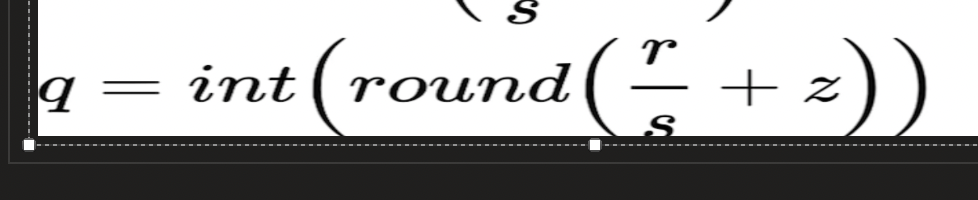

In [2]:
def linear_q_with_scale_and_zeropoint(tensor, scale, zeropoint, dtype=torch.int8):
    scaled_and_linear_shifted_tensor = tensor / scale + zeropoint
    rounded_tensor = torch.round(scaled_and_linear_shifted_tensor)

    # Make sure the quantized tensor is in the range of the min and max quantized value
    # Get min and max quantized value
    min_val = torch.iinfo(dtype).min
    max_val = torch.iinfo(dtype).max

    # Clamp the quantized tensor to the min and max quantized value
    q_tensor = rounded_tensor.clamp(min_val, max_val).to(dtype)
    return q_tensor

## Test Our Quantizer

In [3]:
original_tensor = torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5, -184],
     [0,     684.6,  245.5]]
)

scale = 3.5 
zeropoint = -70


In [4]:
quantized_tensor = linear_q_with_scale_and_zeropoint(original_tensor, scale, zeropoint)
print(quantized_tensor)

tensor([[ -15,  -74,  127],
        [ -44,   14, -123],
        [ -70,  126,    0]], dtype=torch.int8)


## Code Dequantizer using the below formula
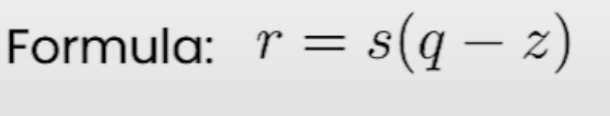
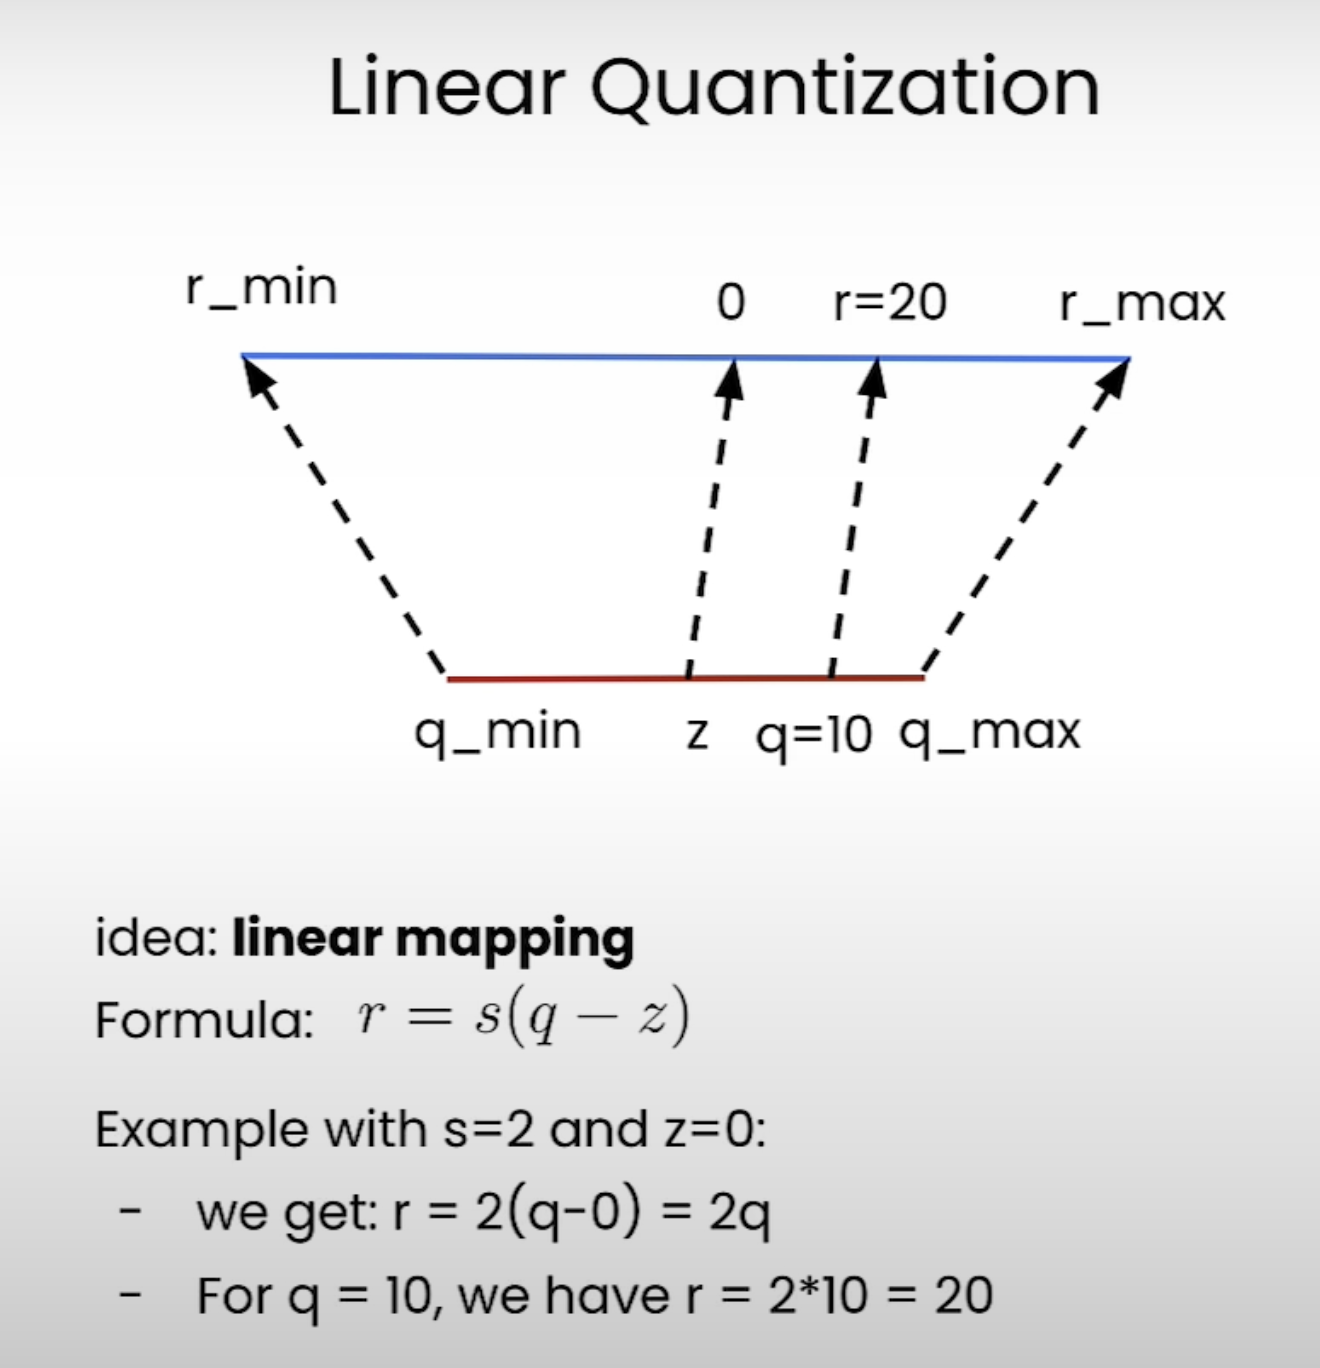

In [5]:
def linear_dequantizer(q_tensor, scale, zeropoint):
    return scale * (q_tensor.float() - zeropoint)

In [6]:
d_tensors = linear_dequantizer(quantized_tensor, scale, zeropoint)
print(d_tensors)

tensor([[ 192.5000,  -14.0000,  689.5000],
        [  91.0000,  294.0000, -185.5000],
        [   0.0000,  686.0000,  245.0000]])


Plot the dequantized values for visualization

In [7]:
def calculate_dequantization_error(original_tensor, dequantized_tensor):
    # Calculate the absolute dequantization error
    error_tensor = torch.abs(dequantized_tensor - original_tensor)
    return error_tensor

def plot_tensors(original_tensor, quantized_tensor, dequantized_tensor, error_tensor):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))

    # Plot original tensor
    sns.heatmap(original_tensor.numpy(), annot=True, fmt=".2f", ax=axs[0], cmap="coolwarm", cbar=False)
    axs[0].set_title("Original Tensor")
    
    # Plot quantized tensor
    sns.heatmap(quantized_tensor.numpy(), annot=True, fmt=".2f", ax=axs[1], cmap="coolwarm", cbar=False)
    axs[1].set_title("8-bit Linear Quantized Tensor")
    
    # Plot dequantized tensor
    sns.heatmap(dequantized_tensor.numpy(), annot=True, fmt=".2f", ax=axs[2], cmap="coolwarm", cbar=False)
    axs[2].set_title("Dequantized Tensor")
    
    # Plot dequantization error tensor
    sns.heatmap(error_tensor.numpy(), annot=True, fmt=".2f", ax=axs[3], cmap="coolwarm", cbar=False)
    axs[3].set_title("Quantization Error Tensor")
    
    plt.show()

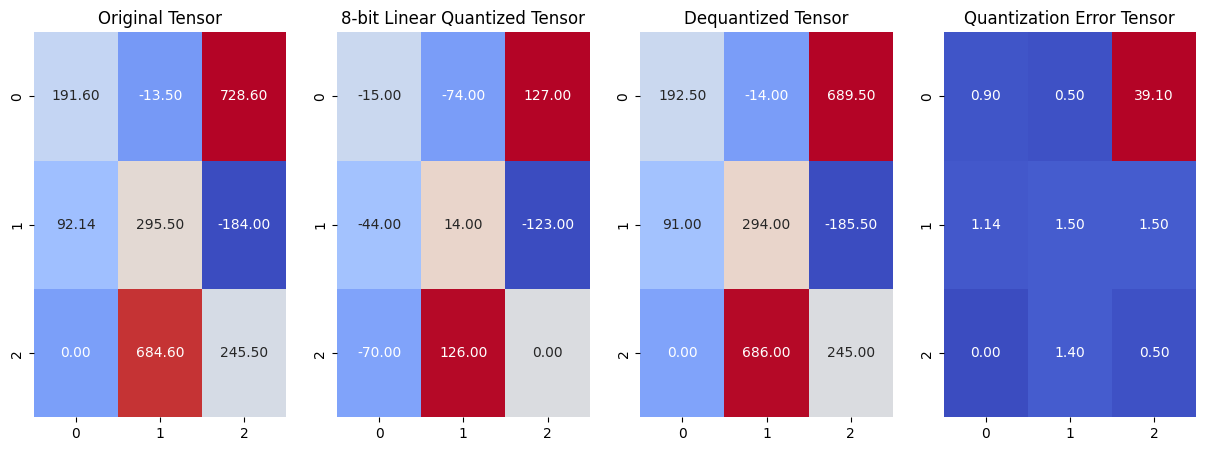

In [8]:
# plot quantization error, by substracting the original tensor from the dequantized tensor and take the absolute value of the entire matrix
# Calculate the dequantization error
dequantization_error_tensor = calculate_dequantization_error(original_tensor, d_tensors)
#plot the quantization error
# Plot the tensors
plot_tensors(original_tensor, quantized_tensor, d_tensors, dequantization_error_tensor)

Dequantization Error Mean

In [9]:
dequantization_error_tensor.square().mean()

tensor(170.8753)

This dequantization error is so high because we assigned random scale value and random zero point

## Finding Optimal Scale value and Zeropoint value



In [12]:
q_max = torch.iinfo(torch.int8).max
q_min =  torch.iinfo(torch.int8).min

print("qmin: ", q_min, "and q_max: ", q_max)

qmin:  -128 and q_max:  127


In [13]:
tensor_min = original_tensor.min().item()
tensor_max = original_tensor.max().item()
print("tensor_min: ", tensor_min, "and tensor_max: ", tensor_max)

tensor_min:  -184.0 and tensor_max:  728.5999755859375


#### Get the scale
scale = (rmax-rmin)/(qmax-qmin)

In [14]:
def get_scale(rmax, rmin, qmax, qmin):
    return (rmax - rmin) / (qmax - qmin)

#### Get Zeropoint
z = q_min - (r_min/scale)

NB: 
To make sure the zeropoint doesn't overflow,  we make sure
- if the zero point is less
than the quantized tensors min(qmin) we set it to qmin 
- if the zeropoint is greater than  the qmax, we set it to qmax

In [17]:
def get_zero_point(rmin, scale, qmin):
    return int(round(qmin - (rmin / scale)))

In [18]:
scale = get_scale(tensor_max, tensor_min, q_max, q_min)
zero_point = get_zero_point(tensor_min, scale, q_min)

print("scale: ", scale, "and zero_point: ", zero_point)

scale:  3.578823433670343 and zero_point:  -77


##### Put all together

In [19]:
def get_q_scale_and_zeropoint(tensor, dtype=torch.int8):
    q_min = torch.iinfo(dtype).min
    q_max = torch.iinfo(dtype).max
    r_min = tensor.min().item()
    r_max = tensor.max().item()

    # get the scale
    scale = (r_max - r_min) / (q_max - q_min)
    # get the zero point
    zero_point = q_min - (r_min / scale)

    #handle zero point overflow
    if zero_point < q_min:
        zero_point = q_min
    elif zero_point > q_max:
        zero_point = q_max
    else:
        zero_point = int(round(zero_point))
    return scale, zero_point


In [26]:
new_scale, new_zero_point = get_q_scale_and_zeropoint(original_tensor)
print(new_scale, new_zero_point)

3.578823433670343 -77


In [29]:
new_quantized_tensor = linear_q_with_scale_and_zeropoint(original_tensor, new_scale, new_zero_point)

In [33]:
new_dequantized_tensor = linear_dequantizer(quantized_tensor, new_scale, new_zero_point)

new_error_tensor = calculate_dequantization_error(original_tensor, new_dequantized_tensor)

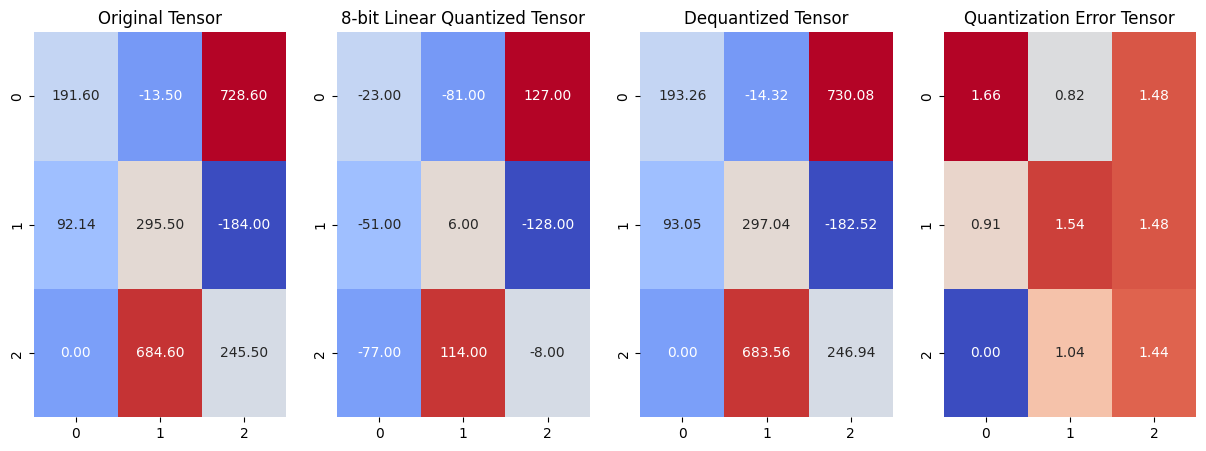

In [34]:
plot_tensors(original_tensor, new_quantized_tensor, new_dequantized_tensor, new_error_tensor)

In [35]:
print(new_error_tensor.square().mean())

tensor(1.5730)


## Create the Linear Quantizer
We can put together everthing we've learned above to create our own linear quantizer

In [36]:
def linear_quantizer(tensors, dtype=torch.int8):
    # Get the scale and zero point
    scale, zero_point = get_q_scale_and_zeropoint(tensors, dtype=dtype)
    # Quantize the tensor
    q_tensor = linear_q_with_scale_and_zeropoint(tensors, scale, zero_point, dtype)
    return q_tensor, scale, zero_point

In [38]:
# test the linear_quantizer function
random_tensor = torch.randn(4, 4)
random_tensor

tensor([[ 0.8233,  1.9884,  0.9990, -0.0688],
        [ 0.8775, -0.3487,  0.2137,  0.5974],
        [ 0.5223, -0.0595,  0.7673, -0.1496],
        [-0.4267, -0.1197, -0.7190, -0.8251]])

In [39]:
q_tensor, scale, zero_point = linear_quantizer(random_tensor)
print(q_tensor, scale, zero_point)

tensor([[  22,  127,   38,  -59],
        [  27,  -85,  -34,    1],
        [  -6,  -58,   17,  -67],
        [ -92,  -64, -118, -128]], dtype=torch.int8) 0.011033531964993945 -53


In [40]:
d_tensors = linear_dequantizer(q_tensor, scale, zero_point)
print(d_tensors)

tensor([[ 0.8275,  1.9860,  1.0041, -0.0662],
        [ 0.8827, -0.3531,  0.2096,  0.5958],
        [ 0.5186, -0.0552,  0.7723, -0.1545],
        [-0.4303, -0.1214, -0.7172, -0.8275]])


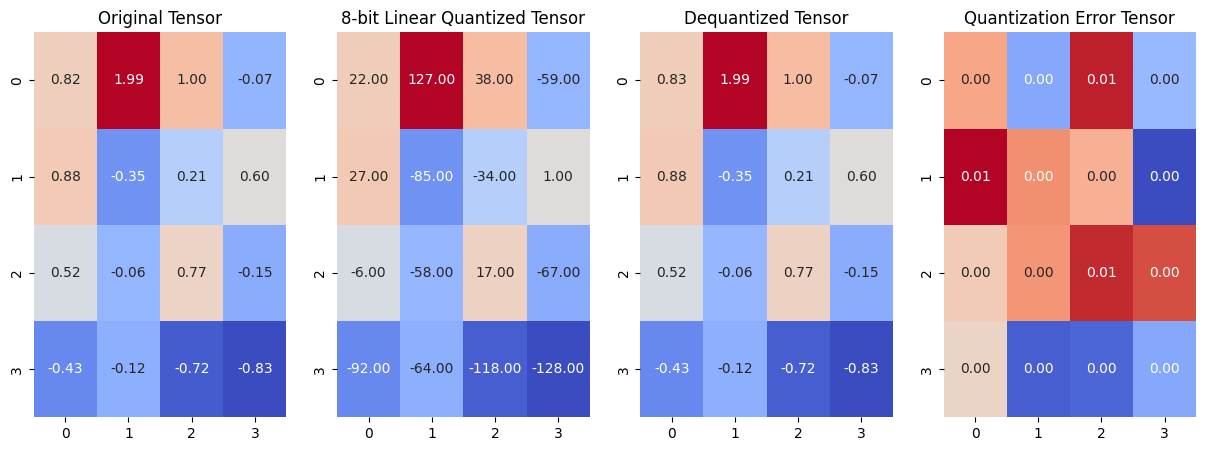

In [41]:
# Plot the different
error_tensor = calculate_dequantization_error(random_tensor, d_tensors)
plot_tensors(random_tensor, q_tensor, d_tensors, error_tensor)

In [42]:
# see the quantization error
print(error_tensor.square().mean())

tensor(1.4233e-05)
